# Network Slimming
- Pruning via L1 on Batchnorm Gammas
- Based on "Learning Efficient Convolutional Networks through Network Slimming"
- CIFAR100 and VGG16
- Soft (setting bn params to 0) and Hard (chaning architecture) pruning strategies
- 50% filter pruning results in 80% of weights pruned
- Using cosine annealing instead of the step scheduling
    - Doesn't work (doesnt reach pre-pruned acc) if trained until last epoch (T_max) and then pruned

In [121]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import vgg16_bn
from torchvision.datasets import CIFAR100

import copy
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

DATASET_ROOT = "/data/datasets/CIFAR100"

In [122]:
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]),
    ]
)


def get_loaders(batch_size=512):
    train_ds = CIFAR100(root=DATASET_ROOT, transform=train_transform, train=True)
    test_ds = CIFAR100(root=DATASET_ROOT, transform=test_transform, train=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def get_bn_l1_loss(model):
    """L1 reg loss for bn gamma"""
    loss = 0
    for layer in model.features:
        if isinstance(layer, nn.BatchNorm2d):
            loss += layer.weight.abs().sum()
    return loss

In [123]:
def evaluate(model, loader) -> float:
    """Get Accuracy"""
    correct = 0
    n_obs = 0
    
    model.eval()
    for X, y in loader:
        X, y = X.cuda(), y.cuda()
        with torch.no_grad():
            out = model(X)
        correct += (out.argmax(dim=1) == y).float().sum()
        n_obs += len(X)
    model.train()    
    
    accuracy = correct / n_obs
    return accuracy.item()


def train(model, n_epochs=200, lr=1e-1, batch_size=512, bn_l1_weight=1e-4,
          initial_lr=None, max_epochs=None, last_epoch=-1):
    """
    :param inital_lr: for finetuning to continue cosine annealing
    :param max_epochs: will stop at n_epochs but max_epochs is needed for scheduling
    :param last_epoch: when finetuning need to specify at what epoch previously stopped
    """
    if initial_lr is None:
        initial_lr = lr
    if max_epochs is None:
        max_epochs = n_epochs
    
    
    model = copy.deepcopy(model).cuda().train()
    train_loader, test_loader = get_loaders(batch_size)
    logs = defaultdict(list)
    criterion = nn.CrossEntropyLoss()
    # Don't as me why but the original implementation uses l1 on top of the l2 for the whole model
    optimiser = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=5e-4)
    optimiser.param_groups[0]['initial_lr'] = initial_lr
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=max_epochs, last_epoch=last_epoch)
    
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        for X, y in train_loader:
            X, y = X.cuda(), y.cuda()
            out = model(X)
            loss = criterion(out, y) + bn_l1_weight * get_bn_l1_loss(model)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

        lr_scheduler.step()
        #logs["train_acc"].append(evaluate(model, train_loader))
        logs["lr"].append(optimiser.state_dict()["param_groups"][0]["lr"])
        logs["test_acc"].append(evaluate(model, test_loader))
        pbar.set_description("Test Acc: {:.4f}%".format(logs['test_acc'][-1] * 100))
    return model, logs


In [4]:
model = vgg16_bn(pretrained=False)

In [13]:
trained_model, trained_logs = train(model, max_epochs=250)

Test Acc: 67.9500%: 100%|██████████| 200/200 [1:05:32<00:00, 19.66s/it]


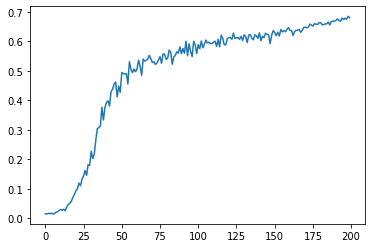

In [14]:
plt.plot(trained_logs["test_acc"])

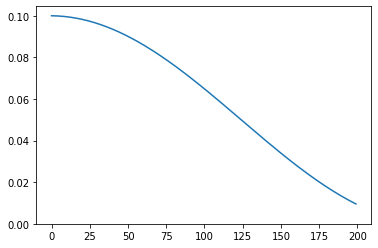

In [159]:
plt.plot(trained_logs["lr"])
plt.ylim(bottom=0)
plt.show()

In [150]:
def get_gammas(model, cat=False):
    """
    Get the gamma parameters of the bn layers
    :param cat: whether to concatenate and all gammas into one tensor.
    """
    res = [bn.weight.view(-1).detach().cpu() for bn in model.features if isinstance(bn, nn.BatchNorm2d)]
    if cat:
        res = torch.cat(res)
    return res

def get_prune_masks(model, percentage=0.5, min_filters_per_layer: int=1) -> list:
    """Reuturns a list of masks of which filters to keep"""
    res = []
    threshold = np.quantile(get_gammas(model, cat=True), percentage)
    bns = [layer for layer in model.features if isinstance(layer, nn.BatchNorm2d)]
    for bn in bns:
        local_threshold = threshold
        # leave at least one filter per layer
        if (bn.weight < local_threshold).float().mean() == 1:
            local_threshold = bn.weight.sort()[0][-min_filters_per_layer].item()
        mask = (bn.weight >= local_threshold).float().detach()  # filters to keep
        res.append(mask)
    return res

def count_filters(model, cat=True):
    gammas = get_gammas(model, cat=False)
    counts = [(l != 0).int().sum().item() for l in gammas]
    if cat == True:
        counts = sum(counts) 
    return counts

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Soft Pruning
- Just setting the BN params to 0, so the whole channel output will be 0 for that filter

In [156]:
def prune_soft(model, percentage=0.5, min_filters_per_layer: int=1):
    """Just set bn gamma and beta to 0 to produce 'unused' filters"""
    model = copy.deepcopy(model.cpu())
    masks = get_prune_masks(model, percentage, min_filters_per_layer)#[:-1]
    bns = [layer for layer in model.features if isinstance(layer, nn.BatchNorm2d)]#[:-1]
    for mask, bn in zip(masks, bns):
        with torch.no_grad():
            bn.weight.mul_(mask)
            bn.bias.mul_(mask)
    return model

Pruned Filters: 0.5
Architecture: [29, 36, 87, 102, 178, 223, 188, 373, 326, 273, 172, 121, 4]


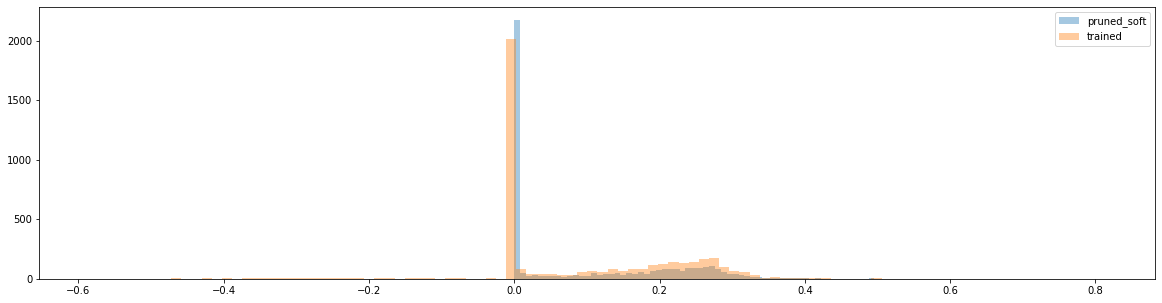

In [161]:
pruned_model_soft = prune_soft(trained_model, percentage=0.5)
print("Pruned Filters:", 1 - count_filters(pruned_model_soft) / count_filters(trained_model))
print("Architecture:", count_filters(pruned_model_soft, cat=False))

plt.figure(figsize=(20, 5))
sns.distplot(get_gammas(pruned_model_soft, cat=True), bins=100, kde=False, label="pruned_soft")
sns.distplot(get_gammas(trained_model, cat=True), bins=100, kde=False, label="trained")
plt.legend()
plt.show()

In [131]:
finetuned_model_soft, finetuned_logs_soft = train(pruned_model_soft, n_epochs=50, lr=trained_logs["lr"][-1], bn_l1_weight=0, initial_lr=0.1, max_epochs=250, last_epoch=200)
print("Final Acc:", finetuned_logs_soft["test_acc"][-1])

Final Acc: 0.6746000051498413


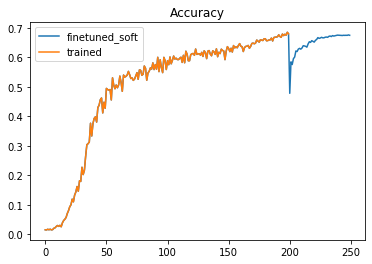

In [136]:
plt.title("Accuracy")
plt.plot(trained_logs["test_acc"] + finetuned_logs_soft["test_acc"], label="finetuned_soft")
plt.plot(trained_logs["test_acc"], label="trained")
plt.legend()
plt.show()

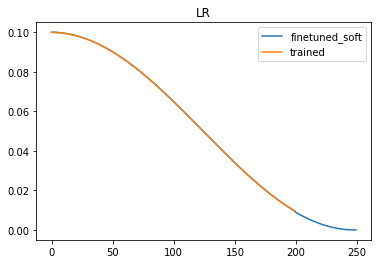

In [137]:
plt.title("LR")
plt.plot(trained_logs["lr"] + finetuned_logs_soft["lr"], label="finetuned_soft")
plt.plot(trained_logs["lr"], label="trained")
plt.legend()
plt.show()

# Hard Pruning
- Actually remove filters and weights by creating a new, pruned model

In [155]:
def prune_hard(model, percentage=0.5, min_filters_per_layer: int=1):
    """Create a new model with a pruned architecture"""
    model = copy.deepcopy(model.cpu())
    masks = get_prune_masks(model, percentage, min_filters_per_layer)
    
    mask_ix = 0
    with torch.no_grad():
        for layer_ix in range(len(model.features)):
            layer = model.features[layer_ix]
            if not isinstance(layer, (nn.Conv2d, nn.BatchNorm2d)):
                continue
            mask_as_indices = masks[mask_ix].nonzero().view(-1)
            if isinstance(layer, nn.Conv2d):
                previous_mask_as_indices = torch.tensor(range(layer.weight.shape[1])) if mask_ix == 0 else masks[mask_ix-1].nonzero().view(-1) 
                new_conv = nn.Conv2d(len(previous_mask_as_indices), len(mask_as_indices), kernel_size=layer.kernel_size, padding=layer.padding)
                new_conv.weight = nn.Parameter(layer.weight[mask_as_indices, :, :, :][:, previous_mask_as_indices, :, :])
                new_conv.bias = nn.Parameter(layer.bias[mask_as_indices])
                model.features[layer_ix] = new_conv
            if isinstance(layer, nn.BatchNorm2d):
                new_bn = nn.BatchNorm2d(len(mask_as_indices))
                new_bn.weight = nn.Parameter(layer.weight[mask_as_indices])
                new_bn.bias = nn.Parameter(layer.bias[mask_as_indices])
                new_bn.running_mean = layer.running_mean[mask_as_indices]
                new_bn.running_var = layer.running_var[mask_as_indices]
                model.features[layer_ix] = new_bn
                mask_ix += 1
        
        # prune classifier, assuming one pixel per filter in last layer (e.g input size to classifier of 512)
        lin_mask = model.avgpool(masks[-1].view(1, -1, 1, 1)).flatten().bool()  # avg pool duplicates each output into a 7x7 shape, ill do the same with the mask to get the right shape for the lin layer
        old_lin = model.classifier[0]
        new_lin = nn.Linear(lin_mask.sum(), old_lin.out_features)
        new_lin.weight = nn.Parameter(old_lin.weight[:, lin_mask])
        new_lin.bias = nn.Parameter(old_lin.bias)
        model.classifier[0] = new_lin
    return model

Pruned Filter: 0.5
Architecture: [29, 36, 87, 102, 178, 223, 188, 373, 326, 273, 172, 121, 4]


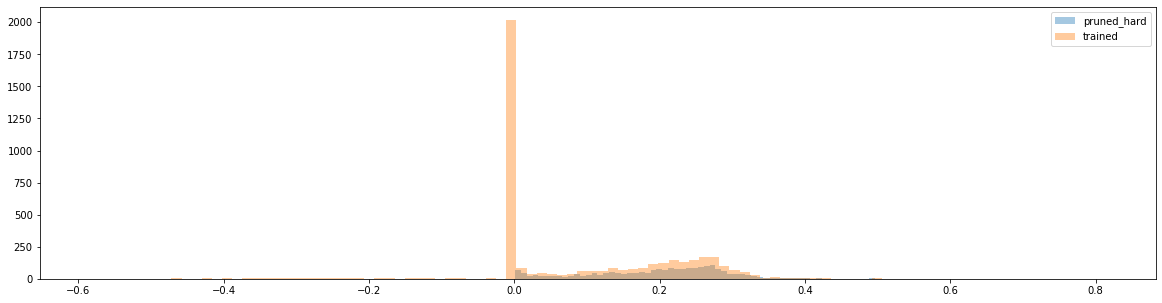

In [160]:
pruned_model_hard = prune_hard(trained_model, percentage=0.5)
print("Pruned Filter:", 1 - count_filters(pruned_model_hard) / count_filters(trained_model))
print("Architecture:", count_filters(pruned_model_hard, cat=False))

plt.figure(figsize=(20, 5))
sns.distplot(get_gammas(pruned_model_hard, cat=True), bins=100, kde=False, label="pruned_hard")
sns.distplot(get_gammas(trained_model, cat=True), bins=100, kde=False, label="trained")
plt.legend()
plt.show()

In [154]:
print("Pruned Parameters:", 1 - count_parameters(pruned_model_hard) / count_parameters(trained_model))

Pruned Parameters: 0.8131874268642543


In [145]:
finetuned_model_hard, finetuned_logs_hard = train(pruned_model_hard, n_epochs=50, lr=trained_logs["lr"][-1], bn_l1_weight=0, initial_lr=0.1, max_epochs=250, last_epoch=200)
print("Final Acc:", finetuned_logs_hard["test_acc"][-1])

Test Acc: 67.5500%: 100%|██████████| 50/50 [10:07<00:00, 12.16s/it]

Final Acc: 0.6754999756813049


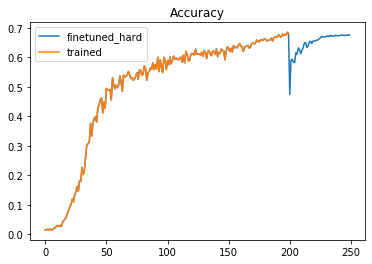

In [147]:
plt.title("Accuracy")
plt.plot(trained_logs["test_acc"] + finetuned_logs_hard["test_acc"], label="finetuned_hard")
plt.plot(trained_logs["test_acc"], label="trained")
plt.legend()
plt.show()

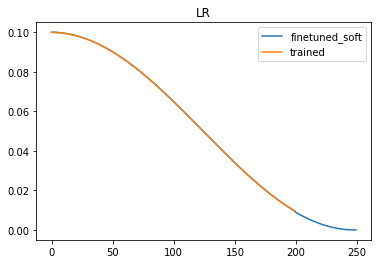

In [148]:
plt.title("LR")
plt.plot(trained_logs["lr"] + finetuned_logs_hard["lr"], label="finetuned_soft")
plt.plot(trained_logs["lr"], label="trained")
plt.legend()
plt.show()

In [149]:
finetuned_model_hard

VGG(
  (features): Sequential(
    (0): Conv2d(3, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(29, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(36, 87, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(87, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(87, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(102, 178, k